Tarea 1: Entrenar un modelo de regresión lineal para predecir el consumo de energía de un edificio de retail conocida la temperatura ambiente
Fecha de entrega: Lunes 19 de Abril.

-Partiendo del colab en el que hemos estado trabajando regresión lineal:
Cree una copia para su modificación. Esta puede ser descargada para ejecutar en su computador o modificarla desde google colab de acuerdo a su preferencia.
Utilice toda la información que se encuentra en el conjunto de datos online para los edificios de tipo retail. Es decir, descargue los archivos para los edificios 1 a 5 y a partir de estos cree un solo conjunto de datos (un único dataframe) en su notebook.

-Realice un análisis exploratorio de los datos similar al hecho en clase. Es posible extenderlo si lo considera necesario.
Busque y aplique otra estrategia para la limpieza de datos. Asegúrese de argumentar porqué usó esa estrategia particular y cómo se compara con la usada en clase. Es interesante poder ver visualmente cómo la limpieza de datos afecta el dataset: graficando los puntos removidos en otro color es una buena forma.

-Realice un primer entrenamiento del modelo y calcule el puntaje (R-cuadrado) de este usando únicamente la información provista en el conjunto de datos. Este modelo servirá como punto de comparación.
Aumente el conjunto de datos agregando predictores cuantitativos como también cualitativos. Compare el puntaje del modelo y argumente si la nueva información es valiosa o no para mejorar la predicción.
Experimento: :cara_de_nerd: ¿qué pasa si usamos la hora del día como una variable categórica en vez de una variable cuantitativa en nuestro modelo? Observe el comportamiento de la temperatura en función de la hora.

-Cree un modelo final con los predictores aumentados. ¿Cuál es el puntaje de este modelo comparado con el modelo inicial?
Yo sé que el notebook que hice está bastante desorganizado :mono_ojos_tapados: Les pido porfa que traten de ser organizados en el de ustedes para poder revisarlo fácilmente.
Por último, suban su notebook (archivo .ipynb) a un repositorio en su cuenta de github. Compartan el link como respuesta a este post.



In [88]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import RobustScaler
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [4]:
#Rutas de los archivos de datos
file1 = "Datos/building1retail.csv"
file2 = "Datos/building2retail.csv"
file3 = "Datos/building3retail.csv"
file4 = "Datos/building4retail.csv"
file5 = "Datos/building5retail.csv"

plts = 'Plots/'

In [5]:
#Carga de datos
df1 = pd.read_csv(file1, index_col=0,parse_dates=True)
df2 = pd.read_csv(file2, index_col=0,parse_dates=True)
df3 = pd.read_csv(file3, index_col=0,parse_dates=True)
df4 = pd.read_csv(file4, index_col=0,parse_dates=True)
df5 = pd.read_csv(file5, index_col=0,parse_dates=True)

In [58]:
#Unión de los 5 archivos de datos y muestra del arreglo resultante
df = pd.concat([df1, df2, df3, df4, df5])
df['T^2'] = df['OAT (F)'] ** 2
df.sample(5)

,OAT (F),Power (kW),T^2
Timestamp,,,
2010-01-27 03:45:00,47,149.2,2209
2010-01-06 21:30:00,55,297.5,3025
2010-08-19 09:00:00,72,363.8,5184
2010-11-14 09:00:00,42,258.1,1764
2010-09-06 20:45:00,72,360.5,5184


Primero verificamos que no hayan valores nulos en ninguna de las columnas con *pandas.DataFrame.isnull().sum()* que devuelve el total de valores nulos en cada columna.

In [59]:
df.isnull().sum()

OAT (F)       0
Power (kW)    0
T^2           0
dtype: int64

Chequeamos que todos los datos de cada columna tengan sean del mismo tipo

In [60]:
df.dtypes

OAT (F)         int64
Power (kW)    float64
T^2             int64
dtype: object

Graficamos la potencia en función de la temperatura y en función de la fecha para visualizar los datos que tenemos

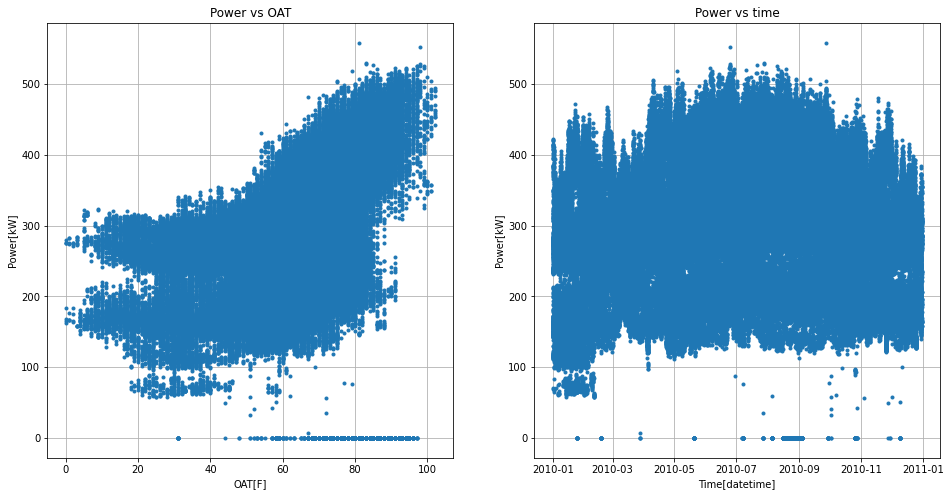

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
axs[0].plot(df['OAT (F)'].values, df['Power (kW)'].values, '.')
axs[0].set_title('Power vs OAT')
axs[0].set_xlabel('OAT[F]')
axs[0].set_ylabel('Power[kW]')
axs[0].grid()
axs[1].plot(df.index.values, df['Power (kW)'].values, '.')
axs[1].set_xlabel('Time[datetime]')
axs[1].set_ylabel('Power[kW]')
axs[1].set_title('Power vs time')
axs[1].grid()
plt.savefig(plts+'v201.jpg')
plt.show()

Graficamos la temperatura contra la fecha para ver si hay una correlación ya que son los dos únicos predictores con los que contamos al inicio.

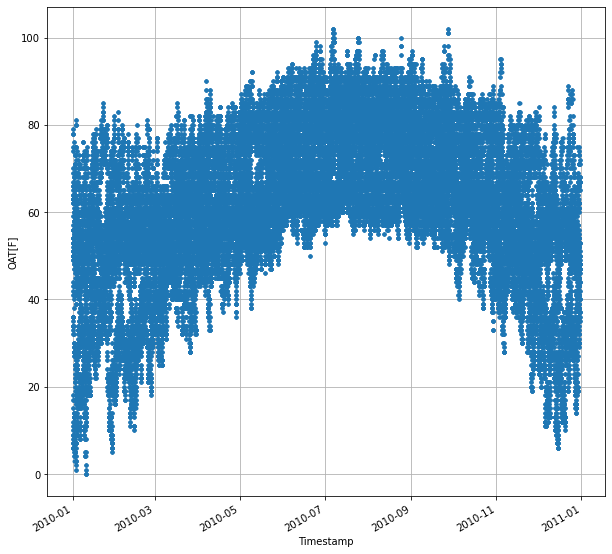

In [62]:
df['OAT (F)'].plot(figsize=(10, 10), marker = '.', linewidth = 0)
plt.ylabel('OAT[F]')
#plt.xlim(df.index.values[0],df.index.values[50])
plt.grid()
plt.savefig(plts+'v202.jpg')

Para ver como están distribuidos los datos de potencia hagamos un histograma y un diagrama de cajas

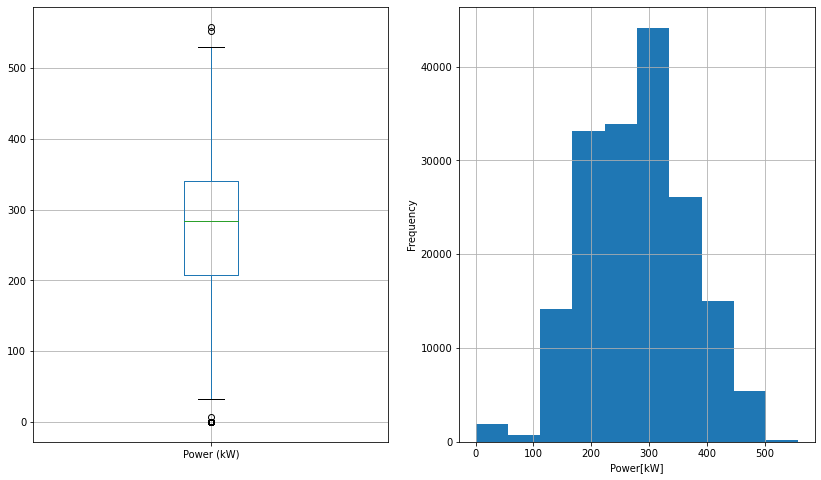

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
df['Power (kW)'].plot(kind = 'hist', ax = axs[1])
df['Power (kW)'].plot(kind = 'box', ax = axs[0])
axs[0].grid()
axs[1].grid()
axs[1].set_xlabel('Power[kW]')
plt.savefig(plts+'v203.jpg')

Antes de limpiar limpiar los datos vamos a escalarlos, esta vez no usando la estandar que mide la distancia al valor promedio en unidades de la desviación estándar sino usando el [RobustScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) de *sklearn.preprocessing* que mide la distancia a la mediana en unidades del rango intercuartil.

StandardScaler
$$x \rightarrow \frac{x - \mu}{\sigma}$$

RobustScaler
$$x \rightarrow \frac{x - m}{Q_3-Q_1}$$

Donde $m$ es la mediana y $Q_3$ y $Q_1$ son el tercer y primer cuartil respectivamente. El motivo de esta elección es porque según el gráfico anterior parece haber *outliers* como los puntos que tienen casi potencia $0$ por ejemplo, y si usamos el *standard* estos puntos afectan el promedio y estaríamos escalando los datos usando unos puntos que lo mejor descartamos luego. El *robust* por su parte parece ser menos sensible a los *outliers* al usar la mediana en lugar del promedio y una distancia entre cuartiles.

[How to Scale Data With Outliers for Machine Learning](https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning)

In [64]:
#Calculo  de la mediana y los cuartiles usados para es escalamiento
transformer = RobustScaler().fit(df)
#Escalamiento o transformación de los datos convertidos en un dataframe
df_tr = pd.DataFrame(transformer.transform(df), index=df.index.values, columns=['OAT','Power','T^2'])
df_tr.head(5)

,OAT,Power,T^2
2010-01-01 01:15:00,-0.47619,-0.888387,-0.426667
2010-01-01 01:30:00,-0.47619,-0.990024,-0.426667
2010-01-01 01:45:00,-0.47619,-1.025409,-0.426667
2010-01-01 02:00:00,-0.47619,-0.974214,-0.426667
2010-01-01 02:15:00,-0.47619,-0.973461,-0.426667


Graficamos los datos escalados

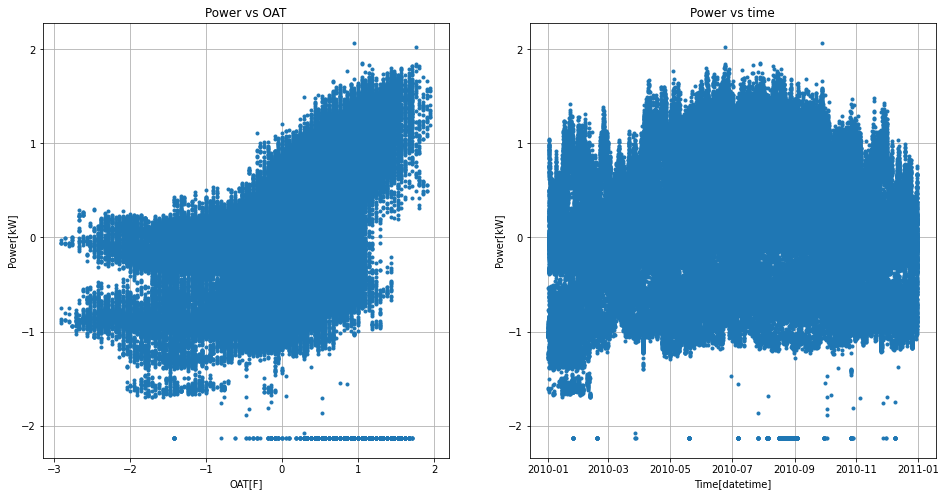

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
axs[0].plot(df_tr['OAT'].values, df_tr['Power'].values, '.')
axs[0].set_xlabel('OAT[F]')
axs[0].set_ylabel('Power[kW]')
axs[0].set_title('Power vs OAT')
axs[0].grid()

axs[1].plot(df_tr.index.values, df_tr['Power'].values, '.')
axs[1].set_xlabel('Time[datetime]')
axs[1].set_ylabel('Power[kW]')
axs[1].set_title('Power vs time')
axs[1].grid()
plt.savefig(plts+'v204.jpg')
plt.show()

Repitamos el histograma y el box plot, podemos ver que los posibles *outliers* están por encima de 2 y poer debajo de -2

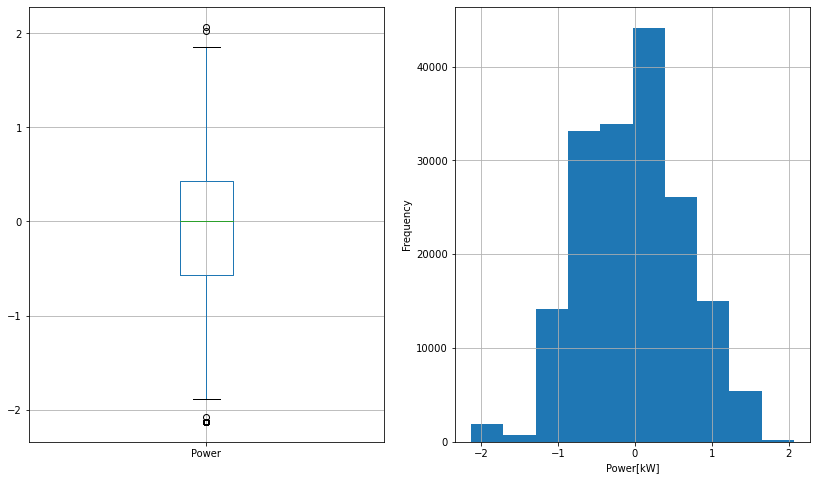

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
df_tr['Power'].plot(kind = 'hist', ax = axs[1])
df_tr['Power'].plot(kind = 'box', ax = axs[0])
axs[0].grid()
axs[1].grid()
axs[1].set_xlabel('Power[kW]')
plt.savefig(plts+'v205.jpg')

Ahora eliminamos los datos que están por debajo de -2 y por encima de 2 que son los que percibimos como *outliers* en los datos escalados

In [67]:
#df_clean = df_tr[np.abs(df_tr['OAT']) < 2]
df_clean = df_tr[np.abs(df_tr['Power']) < 2]
df_del = df_tr[np.abs(df_tr['Power']) > 2]
df_clean.head(5)

,OAT,Power,T^2
2010-01-01 01:15:00,-0.47619,-0.888387,-0.426667
2010-01-01 01:30:00,-0.47619,-0.990024,-0.426667
2010-01-01 01:45:00,-0.47619,-1.025409,-0.426667
2010-01-01 02:00:00,-0.47619,-0.974214,-0.426667
2010-01-01 02:15:00,-0.47619,-0.973461,-0.426667


Graficamos los resultados después de limpiar los datos

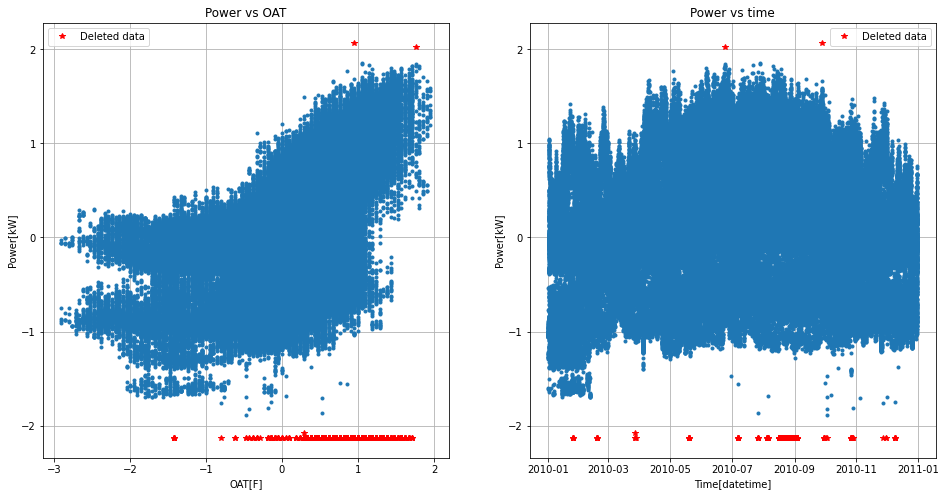

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
axs[0].plot(df_clean['OAT'].values, df_clean['Power'].values, '.')
axs[0].plot(df_del['OAT'].values, df_del['Power'].values, '*r', label = 'Deleted data')

axs[1].plot(df_clean.index.values, df_clean['Power'].values, '.')
axs[1].plot(df_del.index.values, df_del['Power'].values, '*r', label = 'Deleted data')

axs[0].legend()
axs[1].legend()
axs[0].set_xlabel('OAT[F]')
axs[0].set_ylabel('Power[kW]')
axs[0].set_title('Power vs OAT')
axs[0].grid()

axs[1].set_xlabel('Time[datetime]')
axs[1].set_ylabel('Power[kW]')
axs[1].set_title('Power vs time')
axs[1].grid()
plt.savefig(plts+'v206.jpg')
plt.show()

Podemos verificar repitiendo el box plot

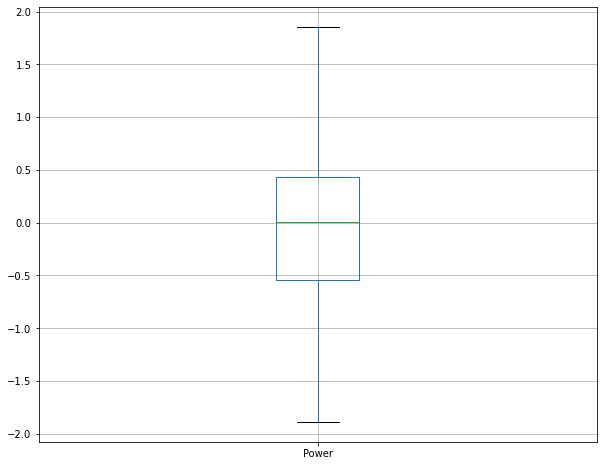

In [69]:
df_clean['Power'].plot(kind = 'box', figsize=(10, 8),)
plt.grid()
plt.savefig(plts+'v207.jpg')

Podemos ver que ahora se ven mucho mejor

In [70]:
x = pd.DataFrame(df_clean['OAT'])
y = pd.DataFrame(df_clean['Power'])

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=np.random.randint(1,100))

In [72]:
linear_model = LinearRegression()
linear_model.fit(x_train,y_train)

LinearRegression()

In [73]:
sc = linear_model.score(x_test, y_test)
sc

0.33915315354014686

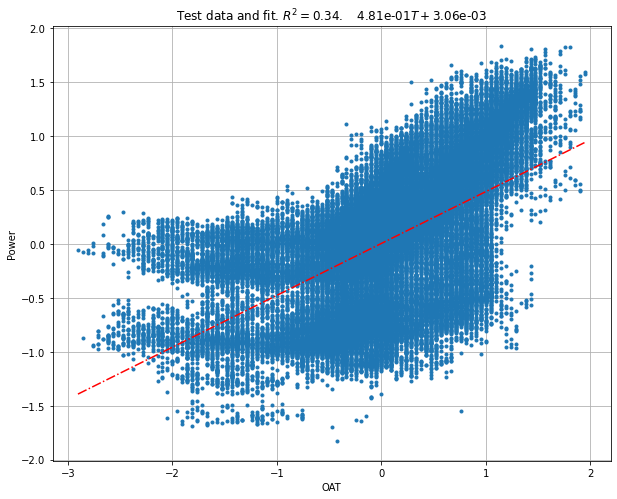

In [74]:
x_fit = np.arange(df_clean['OAT'].min(), df_clean['OAT'].max(), 0.01)
y_fit = linear_model.coef_[0][0] * x_fit + linear_model.intercept_[0]

fig, axs = plt.subplots(1, 1, figsize=(10, 8))
axs.plot(x_test, y_test, '.')
axs.plot(x_fit, y_fit, '-.r')
axs.set_xlabel('OAT')
axs.set_ylabel('Power')
axs.set_title('Test data and fit. $R^2=%.2f$. $\;\;$ %.2e$T+$%.2e'%(sc,linear_model.coef_[0][0], linear_model.intercept_[0]))
plt.grid()
plt.savefig(plts+'v208.jpg')
plt.show()

Ahora vamos a agregar variables a nuestro conjunto de datos, primero vemos que los datos parecen seguir una parábola entonces agregamos una columna de $T^2$. Segundo, mirando los datos de cerca para un par de días vemos que hay un salto en el consumo de energía alrededor de las 8am y otro un poco menos pronunciado a las 11pm entonces vamos a agregar una variable categórica que vale $1$ para $8h \leq t \leq 23h$ y $0$ para el resto.

In [89]:
df_clean['Month'] = df_clean.index.month

In [90]:
df_clean['Open'] = 0
df_clean['Season'] = 0

In [91]:
df_clean['Hour'] = df_clean.index.hour
df_clean.loc[(df_clean['Hour'] >= 8) & (df_clean['Hour'] <= 23),'Open'] = 1
df_clean.loc[(df_clean['Month'] >= 3) & (df_clean['Month'] <= 5), 'Season'] = 1
df_clean.loc[(df_clean['Month'] >= 6) & (df_clean['Month'] <= 8), 'Season'] = 2
df_clean.loc[(df_clean['Month'] >= 9) & (df_clean['Month'] <= 11), 'Season'] = 3
#df['Date'] = df.index.to_julian_date()
df_clean.sample(5)

,OAT,Power,T^2,Month,Open,Season,Hour
2010-10-25 10:45:00,0.428571,0.257482,0.449143,10,1,3,10
2010-04-04 16:45:00,0.714286,-0.345567,0.782857,4,1,1,16
2010-09-13 00:45:00,0.142857,-0.824393,0.142857,9,0,3,0
2010-04-03 03:00:00,0.285714,-0.474308,0.292571,4,0,1,3
2010-10-12 14:45:00,0.857143,0.440429,0.960000,10,1,3,14


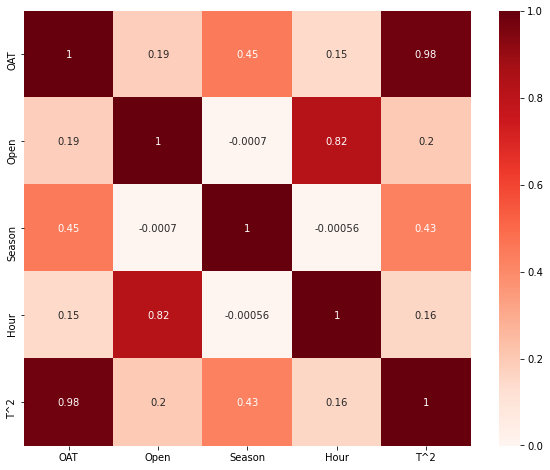

In [56]:
df_corr = df_clean[['OAT','Open','Season','Hour','T^2']].corr()

#plot the correlation matrix of salary, balance and age in data dataframe.
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(df_corr, annot=True, cmap = 'Reds')
plt.savefig(plts+'v209.jpg')
plt.show()

In [29]:
x = pd.DataFrame(df_clean[['OAT','T^2']])
y = pd.DataFrame(df_clean['Power'])

#x = pd.DataFrame(df[['OAT (F)','T^2']])
#y = pd.DataFrame(df['Power (kW)'])

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=np.random.randint(1,100))

In [31]:
linear_model = LinearRegression()
linear_model.fit(x_train,y_train)

LinearRegression()

In [32]:
sc = linear_model.score(x_test, y_test)
sc

0.41097497960800344

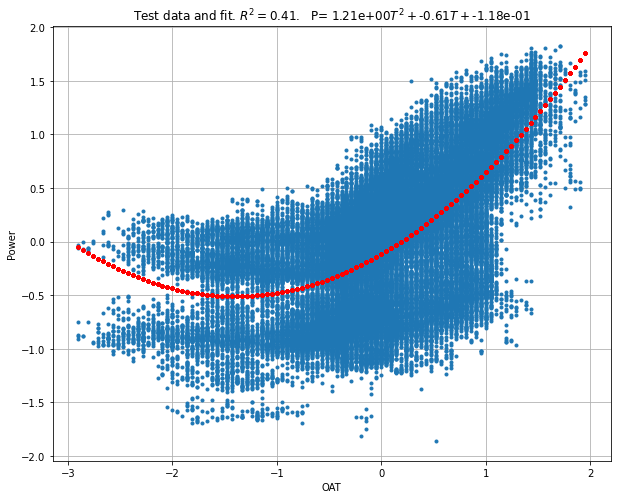

In [33]:
x1_fit = np.linspace(df_clean['OAT'].min(), df_clean['OAT'].max(), 1000)
y_fit = linear_model.coef_[0][1] * x1_fit**2 + linear_model.coef_[0][0] * x1_fit + linear_model.intercept_[0]

y_fit = linear_model.coef_[0][1] * df_clean['T^2'] + linear_model.coef_[0][0] * df_clean['OAT'] + linear_model.intercept_[0]

fig, axs = plt.subplots(1, 1, figsize=(10, 8))
axs.plot(x_test['OAT'], y_test, '.')
axs.plot(df_clean['OAT'].values, y_fit.values, '.r')
axs.set_xlabel('OAT')
axs.set_ylabel('Power')
axs.set_title('Test data and fit. $R^2=%.2f$. $\;\;$P= %0.2e$T^2+$%.2f$T+$%.2e'%(sc,linear_model.coef_[0][1],linear_model.coef_[0][0], linear_model.intercept_[0]))
plt.grid()
plt.savefig(plts+'v210.jpg')
plt.show()

In [34]:
x = pd.DataFrame(df_clean[['OAT','T^2','Open']])
y = pd.DataFrame(df_clean['Power'])

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=np.random.randint(1,100))
linear_model = LinearRegression()
linear_model.fit(x_train,y_train)
sc = linear_model.score(x_test, y_test)
sc

0.7148336962614834

In [36]:
x_op = x_test[x_test['Open'] == 1]
x_cl = x_test[x_test['Open'] == 0]
y_op = y_test[x_test['Open'] == 1]
y_cl = y_test[x_test['Open'] == 0]

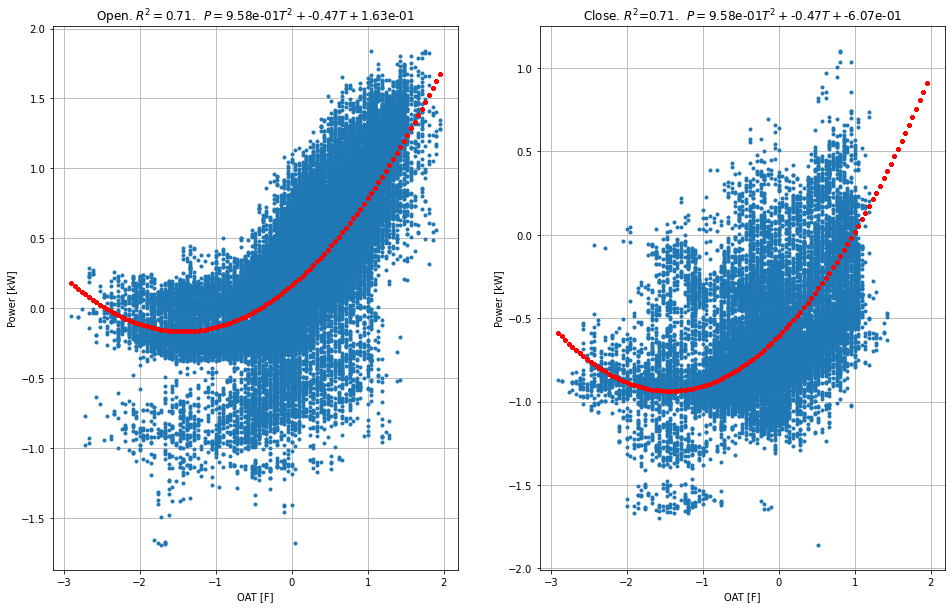

In [37]:
x1_fit = df_clean['OAT'].values
x2_fit = df_clean['T^2'].values
yop_fit = linear_model.coef_[0][1] * x2_fit + linear_model.coef_[0][0] * x1_fit + linear_model.intercept_[0] + linear_model.coef_[0][2]
ycl_fit = linear_model.coef_[0][1] * x2_fit + linear_model.coef_[0][0] * x1_fit + linear_model.intercept_[0]

a = linear_model.coef_[0][1]
b = linear_model.coef_[0][0]
c = linear_model.intercept_[0]
k = linear_model.coef_[0][2]
d = c+k

fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs[0].plot(x_op['OAT'], y_op, '.')
axs[0].set_title('Open. $R^2=$%.2f$.\,\,\,P=$%.2e$T^2+$%.2f$T+$%.2e'%(sc,a,b,d))
axs[0].plot(x1_fit, yop_fit, '.r')
axs[0].set_xlabel('OAT [F]')
axs[0].set_ylabel('Power [kW]')

axs[1].set_title('Close. $R^2$=%.2f$.\,\,\, P=$%.2e$T^2+$%.2f$T+$%.2e'%(sc,a,b,c))
axs[1].plot(x_cl['OAT'], y_cl, '.')
axs[1].plot(x1_fit, ycl_fit, '.r')
axs[1].set_xlabel('OAT [F]')
axs[1].set_ylabel('Power [kW]')

axs[0].grid()
axs[1].grid()
plt.savefig(plts+'v211.jpg')
plt.show()

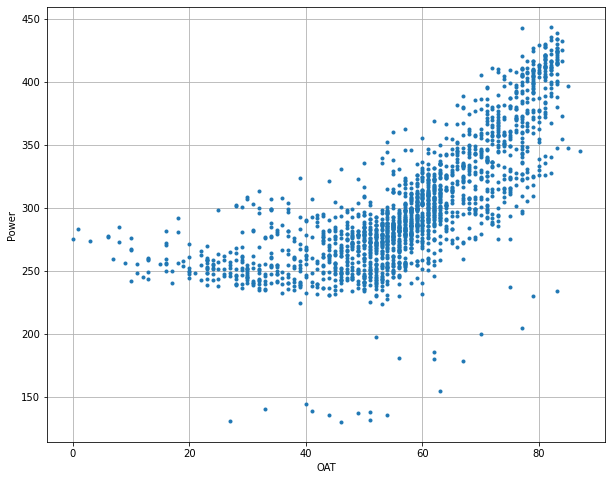

In [ ]:
33df_prueba = df_clean[df_clean['Hour'] == 9]
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
axs.plot(df_prueba['OAT (F)'], df_prueba['Power (kW)'], '.')
axs.set_xlabel('OAT')
axs.set_ylabel('Power')
plt.grid()
plt.show()

In [ ]:
x = pd.DataFrame(df_clean[['OAT','T^2','Hour']])
y = pd.DataFrame(df_clean['Power'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=np.random.randint(1,100))
linear_model = LinearRegression()
linear_model.fit(x_train,y_train)
sc = linear_model.score(x_test, y_test)
sc

0.6325862931408734

In [ ]:
x = pd.DataFrame(df_clean[['OAT','T^2','Season','Open','Hour']])
y = pd.DataFrame(df_clean['Power'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=np.random.randint(1,100))
linear_model = LinearRegression()
linear_model.fit(x_train,y_train)
sc = linear_model.score(x_test, y_test)
sc

0.7163023014875286